In [4]:
import time
from RedistrictingMarkovChain import *

In [15]:
STEPS = [500, 1000] #, 1000, 5000, 10000] #00, 500] #[5000, 10000, 20000]

In [6]:
start_time = time.time()
print("Starting graph load")
ny_graph = Graph.from_file("./NY-lab/NY.shp")
print("Graph loaded")
end_time = time.time()

print(f"Graph load time: {(end_time - start_time) / 60} minutes")

Starting graph load


/Users/travisoleson/anaconda3/envs/ei/lib/python3.11/site-packages/gerrychain/graph/graph.py:388: UserWarning: Found islands (degree-0 nodes). Indices of islands: {134451, 134452}
  warnings.warn(
/Users/travisoleson/anaconda3/envs/ei/lib/python3.11/site-packages/gerrychain/graph/graph.py:262: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


Graph loaded
Graph load time: 8.53423803249995 minutes


In [7]:
election = {"name": "G20PRE", "dem": "G20PRED", "rep": "G20PRER"}

In [8]:
pop_tol = 0.03

In [9]:
ny_markov_chain = RedistrictingMarkovChain(ny_graph,
                                                   26,
                                                   "CD",
                                                   election["name"],
                                                   election["dem"],
                                                   election["rep"],
                                                   "TOTPOP",
                                                   "HISP",
                                                   pop_tol)

In [10]:
ny_markov_chain.init_partition()

In [11]:
def plot_histograms_nb(ensemble, filename, title, xlabel=None, ylabel=None):
    plt.figure()
    plt.title(f"{title} Histogram")
    # plt.axvline(x=5, color="red", linestyle="--", linewidth=2, alpha=0.7)
    if xlabel is not None and ylabel is not None:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.hist(ensemble, align="mid")  # left
    plt.savefig(filename)

500
Walking the ensemble
walking now
Walk complete
Markov Chain time (steps=500): 0.23036266962687174 minutes
1000
Walking the ensemble
walking now
Walk complete
Markov Chain time (steps=1000): 0.3806714614232381 minutes


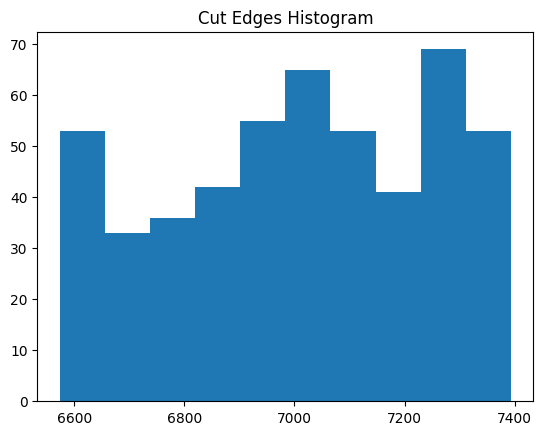

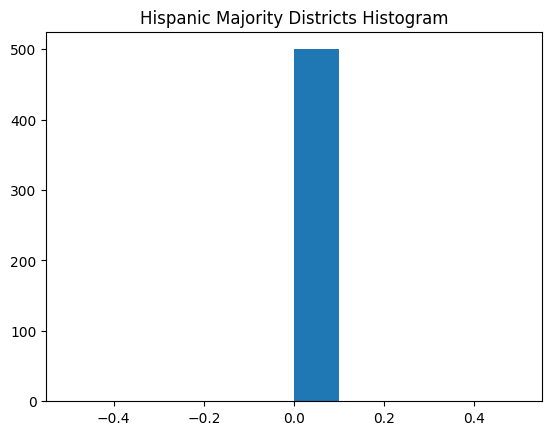

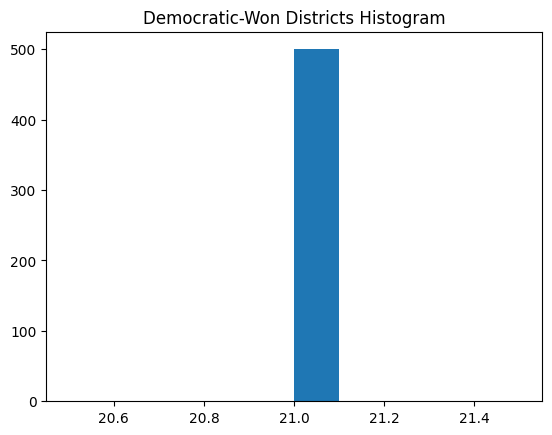

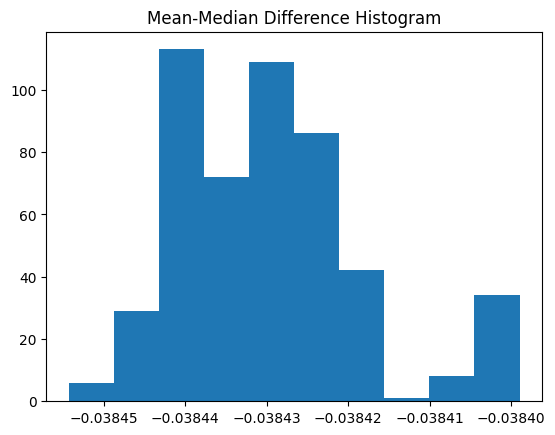

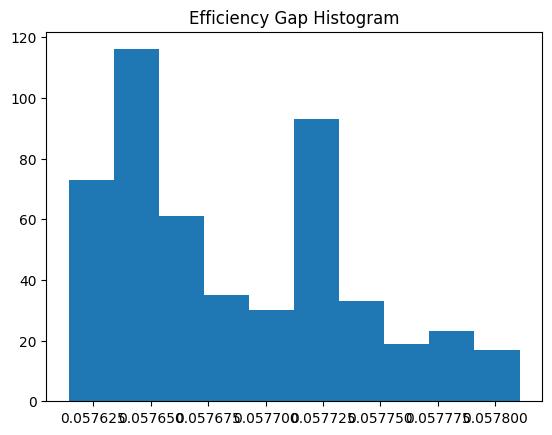

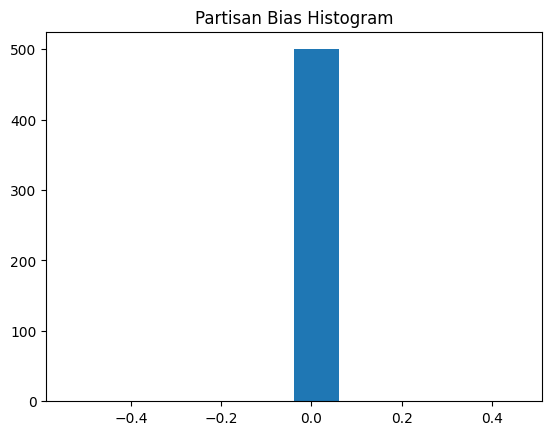

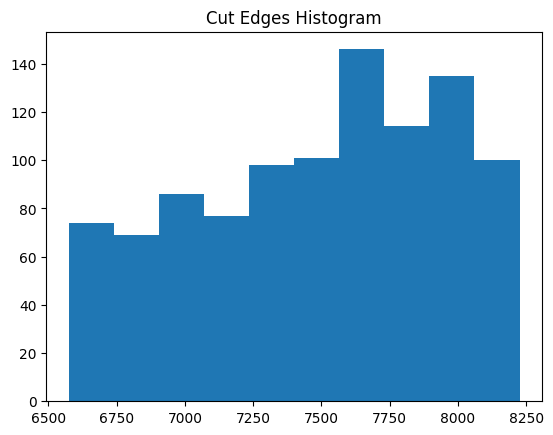

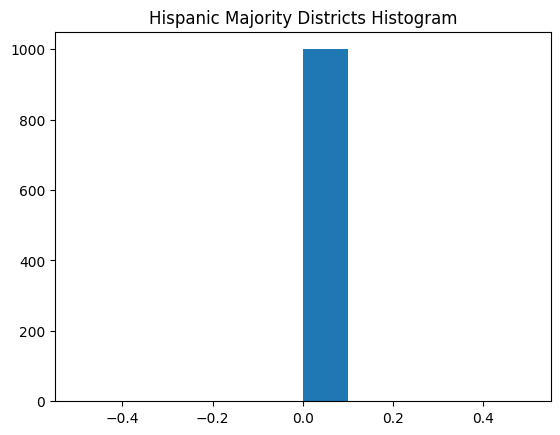

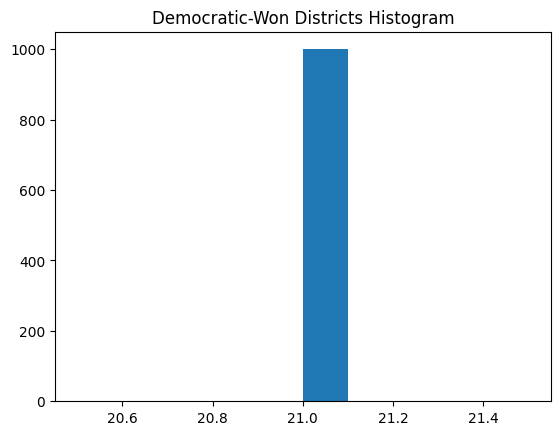

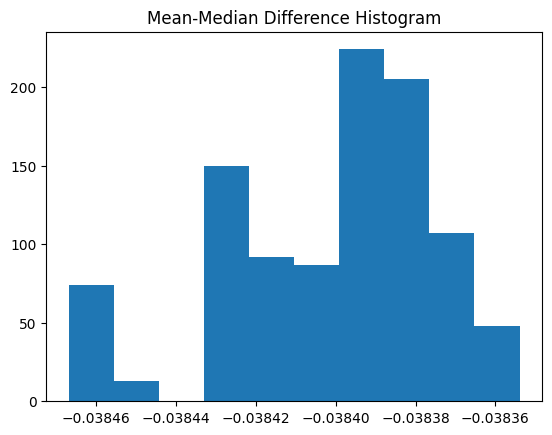

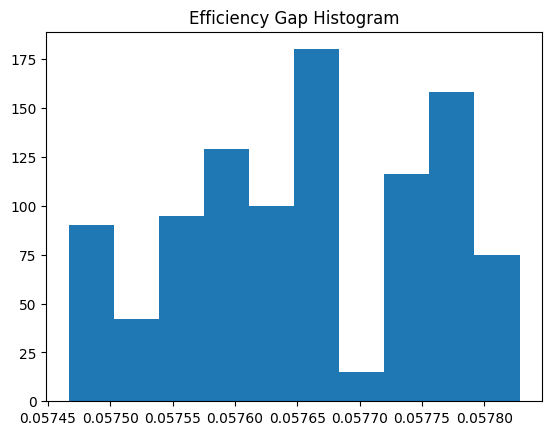

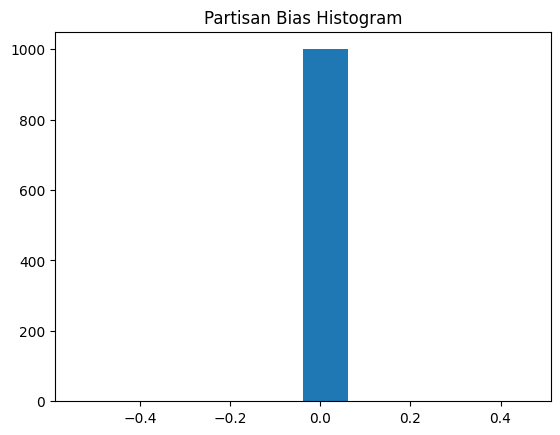

In [16]:
for step in STEPS:
    start_time = time.time()
    ny_markov_chain.init_markov_chain(steps=step)
    cutedge_ensemble, lmaj_ensemble, dem_win_ensemble, mmd_ensemble, eg_ensemble, pb_ensemble  = ny_markov_chain.walk_the_run()

    elec_name = election.get("name")
    # Histograms
    # 1. Cut edge
    plot_histograms_nb(cutedge_ensemble,
                    f"histograms/propose_random_flip_cutedge_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Cut Edges",
                   )
    # 2. Majority-Latino districts
    plot_histograms_nb(lmaj_ensemble,
                    f"histograms/propose_random_flip_lmaj_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Hispanic Majority Districts",
                   )
    # 3. Democratic-won districts
    plot_histograms_nb(dem_win_ensemble,
                    f"histograms/propose_random_flip_dem_win_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Democratic-Won Districts",
                   )

    # 4. Mean-Median Difference
    plot_histograms_nb(mmd_ensemble,
                    f"histograms/propose_random_flip_mmd_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Mean-Median Difference",
                   )

    # 5. Efficiency Gap
    plot_histograms_nb(eg_ensemble,
                    f"histograms/propose_random_flip_eg_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Efficiency Gap",
                   )

    # 6. Partisan Bias
    plot_histograms_nb(pb_ensemble,
                    f"histograms/propose_random_flip_pb_ensemble_{step}_{pop_tol}_{elec_name}.png",
                    "Partisan Bias",
                   )
    end_time = time.time()

    print(f"Markov Chain time (steps={step}): {(end_time - start_time) / 60} minutes")